# Notebook to show evolution of submesoscale eddies for the 0.1 Pa case 
Make plan view plots of surface salinity, normalized relative vorticity, the frontogenesis function, and depth integrated numerical, physical, and total mixing

In [2]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
from datetime import timedelta


In [3]:
path1 = '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_mpdata_uwind_osc_1/shelf_dx_500_mpdata_uwind_osc_1_avg.nc'
path2 = '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_0_f_43N/shelf_dx_500_uwind_0_f_43N_open_avg.nc'
#0.1 Pa case
ds = xroms.open_netcdf(path1)
ds, grid = xroms.roms_dataset(ds)
ds = ds.isel(ocean_time=slice(96,-1))
# ds['ocean_time'] = ds.ocean_time[:]+timedelta(days=4)
#Unforced case
ds1 = xroms.open_netcdf(path2)
ds1, grid1 = xroms.roms_dataset(ds1)
ds1 = ds1.isel(ocean_time=slice(96,-1))

print(ds.ocean_time[0].values)
print(ds1.ocean_time[0].values)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/pyth

0001-01-05 00:30:00
0001-01-05 00:30:00


In [4]:
def to_rho(var):
    if var.dims[-1] != 'xi_rho':
        var = grid.interp(var, 'X', to='center', boundary='extend')
    if var.dims[-2] != 'eta_rho':
        var = grid.interp(var, 'Y', to='center', boundary='extend')
    return var

def norm_fgf(ds,grid):
    qs = ds.salt # tracer 'q' (here salt) at the surface

    dqdx = to_rho(grid.derivative(qs, 'X')) # defined at rho-points
    dqdy = to_rho(grid.derivative(qs, 'Y'))

    us = ds.u # surface velocity field
    vs = ds.v

    dudx = grid.derivative(us, 'X', boundary='extend')
    dvdy = grid.derivative(vs, 'Y', boundary='extend')
    dudy = to_rho(grid.derivative(us, 'Y', boundary='extend'))
    dvdx = to_rho(grid.derivative(vs, 'X', boundary='extend'))

    Dgradq_i = - dudx*dqdx - dvdx*dqdy
    Dgradq_j = - dudy*dqdx - dvdy*dqdy

    # The frontogenesis function
    Ddelq2 = (dqdx*Dgradq_i + dqdy*Dgradq_j)
    Ddelq2.name = 'Frontogenesis function'

    # Density gradients squared
    gradq2 = dqdx**2 + dqdy**2
    gradq2.name = r'$(\nabla q)^2$'

    # Normalized frontogenesis function
    nDGQ2 = Ddelq2 / (gradq2 * ds.f)
    nDGQ2.name = r'Normalized Frontogenesis Function'
    return nDGQ2
nDGQ2 = norm_fgf(ds,grid)
nDGQ2_1 = norm_fgf(ds1,grid1)

In [5]:
def velgrad(ds,grid):
    us = ds.u # surface velocity field
    vs = ds.v

    dudx = grid.derivative(us, 'X', boundary='extend')
    dvdy = grid.derivative(vs, 'Y', boundary='extend')
    dudy = to_rho(grid.derivative(us, 'Y', boundary='extend'))
    dvdx = to_rho(grid.derivative(vs, 'X', boundary='extend'))
    # Vorticity:  v_x - u_y
    zeta = (dvdx - dudy)/ds.f
    # zeta.coords['lon_rho'] = ds.coords['lon_rho']
    # zeta.coords['lat_rho'] = ds.coords['lat_rho']
    zeta.name = 'Normalized vorticity'

    # Divergence: u_x + v_y
    delta = (dudx + dvdy)/ds.f
    # delta.coords['lon_rho'] = ds.coords['lon_rho']
    # delta.coords['lat_rho'] = ds.coords['lat_rho']
    delta.name = 'Normalized divergence'

    # Major axis of deformation
    alpha = ( np.sqrt( (dudx-dvdy)**2 + (dvdx+dudy)**2 ) )/ds.f
    # alpha.coords['lon_rho'] = ds.coords['lon_rho']
    # alpha.coords['lat_rho'] = ds.coords['lat_rho']
    alpha.name = 'Normalized strain'

    # Principle deformation components
    lminor = 0.5 * (delta - alpha)
    # lminor.coords['lon_rho'] = ds.coords['lon_rho']
    # lminor.coords['lat_rho'] = ds.coords['lat_rho']
    lminor.name = 'lambda minor'

    lmajor = 0.5 * (delta + alpha)
    # lmajor.coords['lon_rho'] = ds.coords['lon_rho']
    # lmajor.coords['lat_rho'] = ds.coords['lat_rho']
    lmajor.name = 'lambda major'
    
    return zeta,delta,alpha,lminor,lmajor

zeta,delta,alpha,lminor,lmajor = velgrad(ds,grid)
zeta1,delta1,alpha1,lminor1,lmajor1= velgrad(ds1,grid1)

In [6]:
def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points

    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_rho(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_rho(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

sgradmag = surface_saltgradmag(ds, grid)
sgradmag1 = surface_saltgradmag(ds1, grid1)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(2, 87, '(p)')

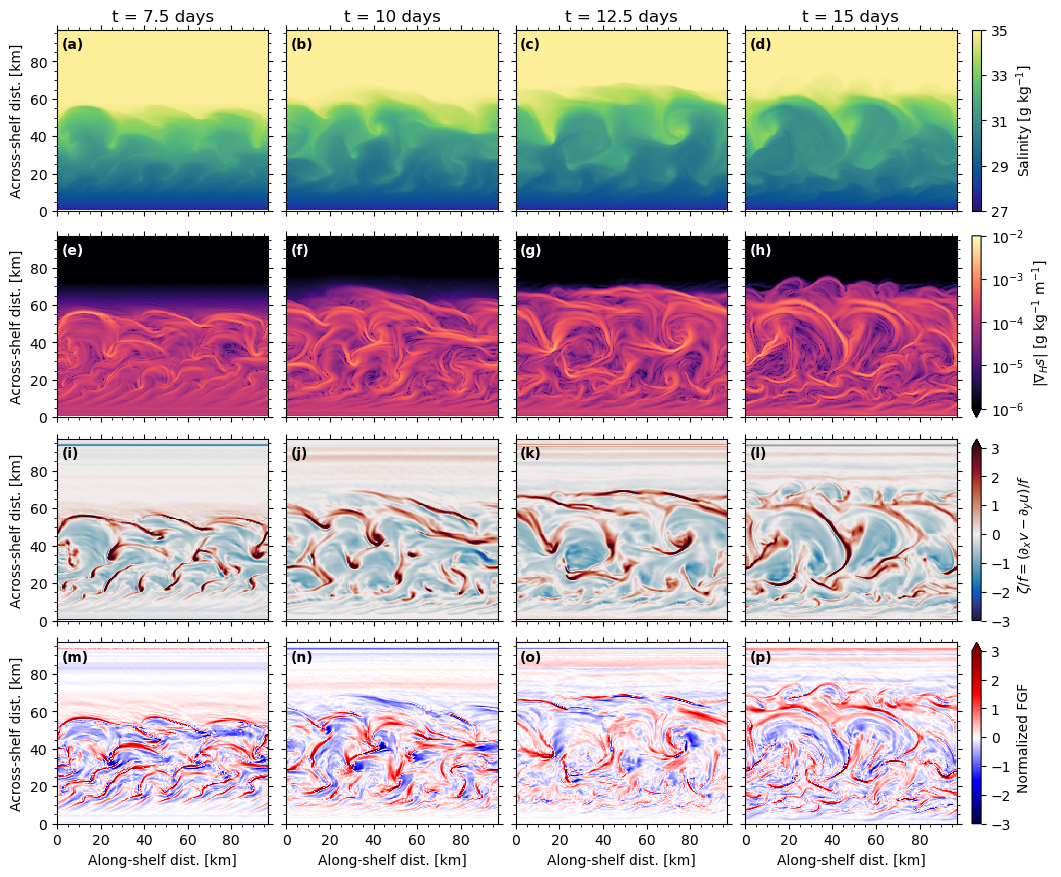

In [7]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(4,4, figsize = ((7/2)*3,8.66), constrained_layout = True)

#salt
xrho = (ds.x_rho/1000)[1:].values
yrho = (ds.y_rho/1000)[1:].values

mappable1 = ax[0,0].pcolormesh(xrho, yrho, ds.salt[156-96,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable2 = ax[0,1].pcolormesh(xrho, yrho, ds.salt[216-96,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable3 = ax[0,2].pcolormesh(xrho, yrho, ds.salt[276-96,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable4 = ax[0,3].pcolormesh(xrho, yrho, ds.salt[336-96,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)

cbar = fig.colorbar(mappable4, ax = ax[0,3], label = '', ticks = [27, 29, 31, 33, 35],)
cbar.ax.set_ylabel(r'Salinity [g kg$^{-1}$]')

sfill = sgradmag[156-96,1:].where(sgradmag[156-96,1:]>1e-6)
sfill0 = sfill.fillna(value=1e-6)
sfill1 = sgradmag[216-96,1:].where(sgradmag[216-96,1:]>1e-6)
sfill01 = sfill1.fillna(value=1e-6)
sfill2 = sgradmag[276-96,1:].where(sgradmag[276-96,1:]>1e-6)
sfill02 = sfill2.fillna(value=1e-6)
sfill3 = sgradmag[336-96,1:].where(sgradmag[336-96,1:]>1e-6)
sfill03 = sfill3.fillna(value=1e-6)

mappable5 = ax[1,0].pcolormesh(xrho, yrho, np.log10(sfill0), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable6 = ax[1,1].pcolormesh(xrho, yrho, np.log10(sfill01), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable7 = ax[1,2].pcolormesh(xrho, yrho, np.log10(sfill02), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable8 = ax[1,3].pcolormesh(xrho, yrho, np.log10(sfill03), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
cbar = fig.colorbar(mappable8, ax = ax[1,3], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%d}$'))
cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

mappable9 = ax[2,0].pcolormesh(xrho, yrho, zeta[156-96,-1,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable10 = ax[2,1].pcolormesh(xrho, yrho, zeta[216-96,-1,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable11 = ax[2,2].pcolormesh(xrho, yrho, zeta[276-96,-1,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable12 = ax[2,3].pcolormesh(xrho, yrho, zeta[336-96,-1,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable12, ax = ax[2,3], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$\zeta/f=(\partial_x v - \partial_y u)/f$')

mappable13 = ax[3,0].pcolormesh(xrho, yrho, nDGQ2[156-96,-1,1:], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
mappable14 = ax[3,1].pcolormesh(xrho, yrho, nDGQ2[216-96,-1,1:], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
mappable15 = ax[3,2].pcolormesh(xrho, yrho, nDGQ2[276-96,-1,1:], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
mappable16 = ax[3,3].pcolormesh(xrho, yrho, nDGQ2[336-96,-1,1:], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable16, ax = ax[3,3], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'Normalized FGF')

for i in range(4):
    for j in range(4):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Across-shelf dist. [km]')
        ax[3,j].set_xlabel('Along-shelf dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        ax[i,3].set_yticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)

for i in range(3):
    for j in range(4):
        ax[i,j].set_xticklabels([])

ax[0,0].set_title(r't = 7.5 days')
ax[0,1].set_title(r't = 10 days')
ax[0,2].set_title(r't = 12.5 days')
ax[0,3].set_title(r't = 15 days')

ax[0,0].text(2,87, '(a)', fontweight = 'semibold')
ax[0,1].text(2,87, '(b)', fontweight = 'semibold')
ax[0,2].text(2,87, '(c)', fontweight = 'semibold')
ax[0,3].text(2,87, '(d)', fontweight = 'semibold')
ax[1,0].text(2,87, '(e)', fontweight = 'semibold', color = 'white')
ax[1,1].text(2,87, '(f)', fontweight = 'semibold', color = 'white')
ax[1,2].text(2,87, '(g)', fontweight = 'semibold', color = 'white')
ax[1,3].text(2,87, '(h)', fontweight = 'semibold', color = 'white')
ax[2,0].text(2,87, '(i)', fontweight = 'semibold')
ax[2,1].text(2,87, '(j)', fontweight = 'semibold')
ax[2,2].text(2,87, '(k)', fontweight = 'semibold')
ax[2,3].text(2,87, '(l)', fontweight = 'semibold')
ax[3,0].text(2,87, '(m)', fontweight = 'semibold')
ax[3,1].text(2,87, '(n)', fontweight = 'semibold')
ax[3,2].text(2,87, '(o)', fontweight = 'semibold')
ax[3,3].text(2,87, '(p)', fontweight = 'semibold')
# plt.savefig('surface_properties_fronts.jpg', dpi = 300, bbox_inches='tight')

# Now compute the mixing with the top m and the top 15 m, then plot 

In [44]:
mnum_z1 = ((ds.dye_03*ds.dz).where(ds.z_rho>-1)).sum('s_rho')
mphy_z1 = ((grid.interp(ds.AKr,'Z')*ds.dz).where(ds.z_rho>-1)).sum('s_rho')
mnum_z15 = ((ds.dye_03*ds.dz).where(ds.z_rho>-15)).sum('s_rho')
mphy_z15 = ((grid.interp(ds.AKr,'Z')*ds.dz).where(ds.z_rho>-15)).sum('s_rho')

akr_rho = grid.interp(ds.AKr,'Z')
mtot = (ds.dye_03+akr_rho)
mtot_z1 = (mtot*ds.dz).where(ds.z_rho>-1).sum('s_rho')
mtot_z15 = (mtot*ds.dz).where(ds.z_rho>-15).sum('s_rho')

print(mnum_z1[240,1:100].values.sum()/(mphy_z1[240,1:100].values).sum())
print(mphy_z1[240,1:100].values.sum()/(mtot_z1[240,1:100].values).sum())
print(mnum_z1[240,1:100].values.sum()/(mtot_z1[240,1:100].values).sum())

print(mnum_z15[240,1:100].values.sum()/(mphy_z15[240,1:100].values).sum())
print(mnum_z15[240,1:100].values.sum()/(mtot_z15[240,1:100].values).sum())
print(mphy_z15[240,1:100].values.sum()/(mtot_z15[240,1:100].values).sum())
# print(mnum_z15[60:240,1:100].values.sum()/(mphy_z15[60:240,1:100].values).sum())
# print(mnum_z1[60:240,1:100].values.sum()/(mphy_z1[60:240,1:100].values).sum())

1.582479197355111
0.3872248042146361
0.6127751973695673
0.23104915349816316
0.18768475065899534
0.8123152490168609


In [41]:
336-96

240

/tmp/ipykernel_21624/4021074132.py:10: RuntimeWarning: divide by zero encountered in log10
  mappable21 = ax[1,0].pcolormesh(xrho, yrho, np.log10(np.abs(mphy_z1[156-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
/tmp/ipykernel_21624/4021074132.py:11: RuntimeWarning: divide by zero encountered in log10
  mappable22 = ax[1,1].pcolormesh(xrho, yrho, np.log10(np.abs(mphy_z1[216-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
/tmp/ipykernel_21624/4021074132.py:12: RuntimeWarning: divide by zero encountered in log10
  mappable23 = ax[1,2].pcolormesh(xrho, yrho, np.log10(np.abs(mphy_z1[276-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
/tmp/ipykernel_21624/4021074132.py:13: RuntimeWarning: divide by zero encountered in log10
  mappable24 = ax[1,3].pcolormesh(xrho, yrho, np.log10(np.abs(mphy_z1[336-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
/tmp/ipykernel_21624/4021074132.py:23: RuntimeWarnin

Text(35, 87, '[(g kg$^{-1}$)$^2$ s$^{-1}$ m]')

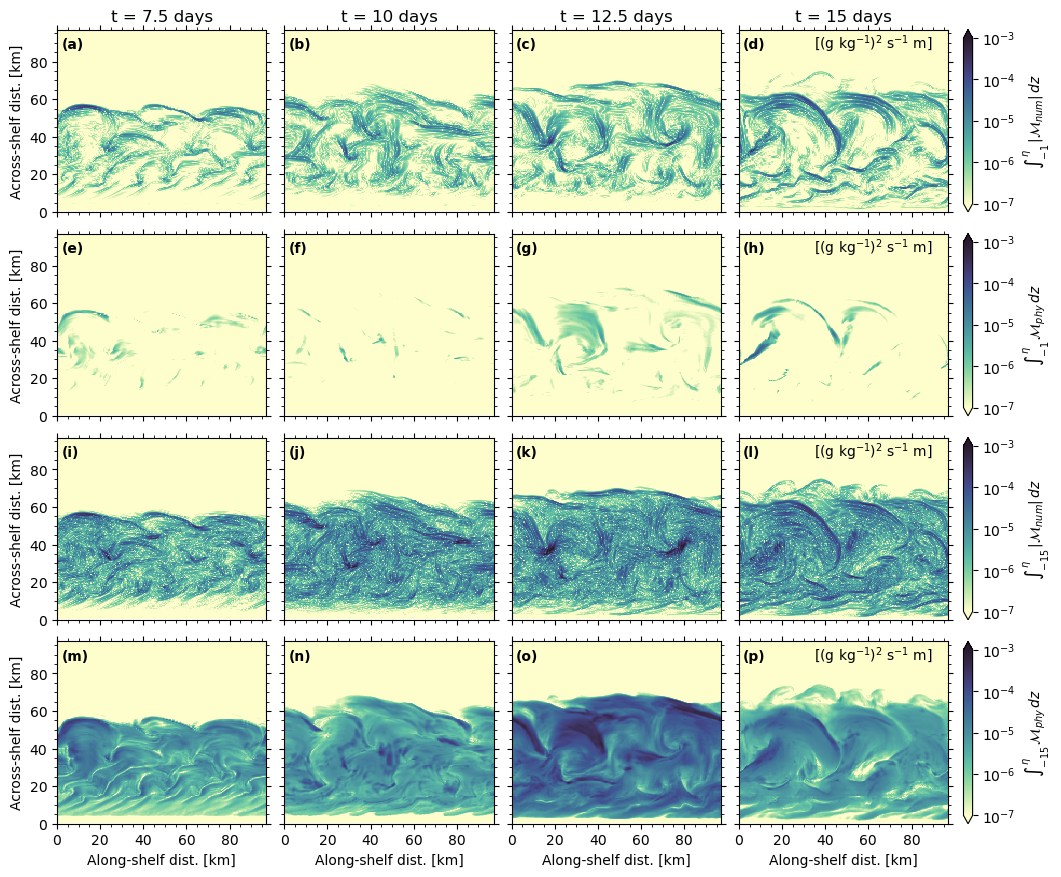

In [9]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(4,4, figsize = ((7/2)*3,(8.66/4*4)), constrained_layout = True)

mappable17 = ax[0,0].pcolormesh(xrho, yrho, np.log10(np.abs(mnum_z1[156-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
mappable18 = ax[0,1].pcolormesh(xrho, yrho, np.log10(np.abs(mnum_z1[216-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
mappable19 = ax[0,2].pcolormesh(xrho, yrho, np.log10(np.abs(mnum_z1[276-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
mappable20 = ax[0,3].pcolormesh(xrho, yrho, np.log10(np.abs(mnum_z1[336-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
cbar = fig.colorbar(mappable20, ax = ax[0,3], label = r'$\int_{-1}^\eta \, |\mathcal{M}_{num}| \, dz$', extend = 'both', format=tick.FormatStrFormatter('$10^{%d}$'))

mappable21 = ax[1,0].pcolormesh(xrho, yrho, np.log10(np.abs(mphy_z1[156-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
mappable22 = ax[1,1].pcolormesh(xrho, yrho, np.log10(np.abs(mphy_z1[216-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
mappable23 = ax[1,2].pcolormesh(xrho, yrho, np.log10(np.abs(mphy_z1[276-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
mappable24 = ax[1,3].pcolormesh(xrho, yrho, np.log10(np.abs(mphy_z1[336-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
cbar = fig.colorbar(mappable24, ax = ax[1,3], label = r'$\int_{-1}^\eta \, \mathcal{M}_{phy} \, dz$', extend = 'both', format=tick.FormatStrFormatter('$10^{%d}$'))


mappable17 = ax[2,0].pcolormesh(xrho, yrho, np.log10(np.abs(mnum_z15[156-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
mappable18 = ax[2,1].pcolormesh(xrho, yrho, np.log10(np.abs(mnum_z15[216-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
mappable19 = ax[2,2].pcolormesh(xrho, yrho, np.log10(np.abs(mnum_z15[276-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
mappable20 = ax[2,3].pcolormesh(xrho, yrho, np.log10(np.abs(mnum_z15[336-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
cbar = fig.colorbar(mappable20, ax = ax[2,3], label = r'$\int_{-15}^\eta \, |\mathcal{M}_{num}| \, dz$', extend = 'both', format=tick.FormatStrFormatter('$10^{%d}$'))

mappable21 = ax[3,0].pcolormesh(xrho, yrho, np.log10(np.abs(mphy_z15[156-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
mappable22 = ax[3,1].pcolormesh(xrho, yrho, np.log10(np.abs(mphy_z15[216-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
mappable23 = ax[3,2].pcolormesh(xrho, yrho, np.log10(np.abs(mphy_z15[276-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
mappable24 = ax[3,3].pcolormesh(xrho, yrho, np.log10(np.abs(mphy_z15[336-96,1:].values)), cmap = plt.get_cmap('cmo.deep'), vmin = -7, vmax = -3)
cbar = fig.colorbar(mappable24, ax = ax[3,3], label = r'$\int_{-15}^\eta \, \mathcal{M}_{phy} \, dz$', extend = 'both', format=tick.FormatStrFormatter('$10^{%d}$'))

for i in range(4):
    for j in range(4):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Across-shelf dist. [km]')
        ax[3,j].set_xlabel('Along-shelf dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        ax[i,3].set_yticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)

for i in range(3):
    for j in range(4):
        ax[i,j].set_xticklabels([])

ax[0,0].set_title(r't = 7.5 days')
ax[0,1].set_title(r't = 10 days')
ax[0,2].set_title(r't = 12.5 days')
ax[0,3].set_title(r't = 15 days')

ax[0,0].text(2,87, '(a)', fontweight = 'semibold')
ax[0,1].text(2,87, '(b)', fontweight = 'semibold')
ax[0,2].text(2,87, '(c)', fontweight = 'semibold')
ax[0,3].text(2,87, '(d)', fontweight = 'semibold')
ax[0,3].text(35,87,'[(g kg$^{-1}$)$^2$ s$^{-1}$ m]')
ax[1,0].text(2,87, '(e)', fontweight = 'semibold')
ax[1,1].text(2,87, '(f)', fontweight = 'semibold')
ax[1,2].text(2,87, '(g)', fontweight = 'semibold')
ax[1,3].text(2,87, '(h)', fontweight = 'semibold')
ax[1,3].text(35,87,'[(g kg$^{-1}$)$^2$ s$^{-1}$ m]')
ax[2,0].text(2,87, '(i)', fontweight = 'semibold')
ax[2,1].text(2,87, '(j)', fontweight = 'semibold')
ax[2,2].text(2,87, '(k)', fontweight = 'semibold')
ax[2,3].text(2,87, '(l)', fontweight = 'semibold')
ax[2,3].text(35,87,'[(g kg$^{-1}$)$^2$ s$^{-1}$ m]')
ax[3,0].text(2,87, '(m)', fontweight = 'semibold')
ax[3,1].text(2,87, '(n)', fontweight = 'semibold')
ax[3,2].text(2,87, '(o)', fontweight = 'semibold')
ax[3,3].text(2,87, '(p)', fontweight = 'semibold')
ax[3,3].text(35,87,'[(g kg$^{-1}$)$^2$ s$^{-1}$ m]')

# plt.savefig('surface_properties_mix.jpg', dpi = 300, bbox_inches='tight')

## Remake the two figures. 
Show 4 panels, salt and vorticity. Then split into a 3X3. shgrad, delta/f, NFGF, mnum, mphy, and mtot integrated in top 1 m. 

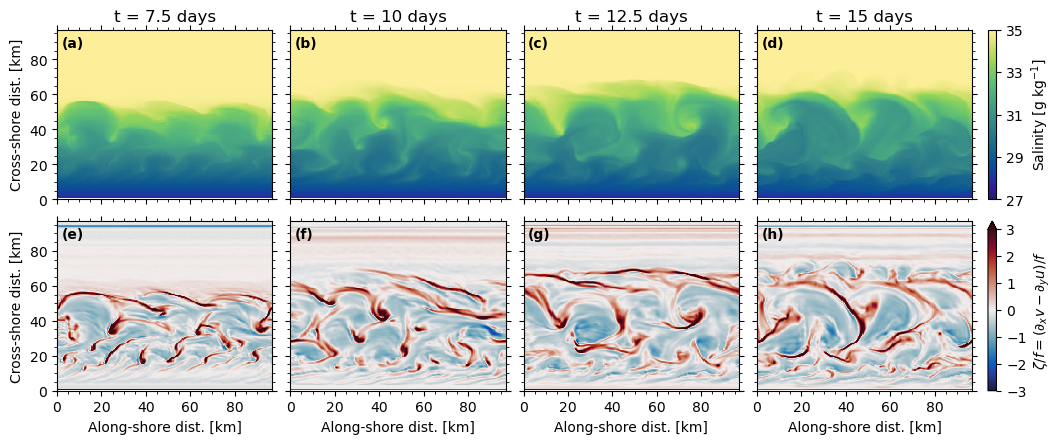

In [12]:
fig, ax = plt.subplots(2,4, figsize = ((7/2)*3,(8.66/4)*2), constrained_layout = True)

xrho = (ds.x_rho/1000)[1:].values
yrho = (ds.y_rho/1000)[1:].values

mappable1 = ax[0,0].pcolormesh(xrho, yrho, ds.salt[156-96,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable2 = ax[0,1].pcolormesh(xrho, yrho, ds.salt[216-96,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable3 = ax[0,2].pcolormesh(xrho, yrho, ds.salt[276-96,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable4 = ax[0,3].pcolormesh(xrho, yrho, ds.salt[336-96,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)

cbar = fig.colorbar(mappable4, ax = ax[0,3], label = '', ticks = [27, 29, 31, 33, 35],)
cbar.ax.set_ylabel(r'Salinity [g kg$^{-1}$]')

mappable9 = ax[1,0].pcolormesh(xrho, yrho, zeta[156-96,-1,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable10 = ax[1,1].pcolormesh(xrho, yrho, zeta[216-96,-1,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable11 = ax[1,2].pcolormesh(xrho, yrho, zeta[276-96,-1,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable12 = ax[1,3].pcolormesh(xrho, yrho, zeta[336-96,-1,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable12, ax = ax[1,3], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$\zeta/f=(\partial_x v - \partial_y u)/f$')

for i in range(2):
    for j in range(4):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Cross-shore dist. [km]')
        ax[1,j].set_xlabel('Along-shore dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        ax[i,3].set_yticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)

for j in range(4):
    ax[0,j].set_xticklabels([])

ax[0,0].set_title(r't = 7.5 days')
ax[0,1].set_title(r't = 10 days')
ax[0,2].set_title(r't = 12.5 days')
ax[0,3].set_title(r't = 15 days')

ax[0,0].text(2,87, '(a)', fontweight = 'semibold')
ax[0,1].text(2,87, '(b)', fontweight = 'semibold')
ax[0,2].text(2,87, '(c)', fontweight = 'semibold')
ax[0,3].text(2,87, '(d)', fontweight = 'semibold')
ax[1,0].text(2,87, '(e)', fontweight = 'semibold')
ax[1,1].text(2,87, '(f)', fontweight = 'semibold')
ax[1,2].text(2,87, '(g)', fontweight = 'semibold')
ax[1,3].text(2,87, '(h)', fontweight = 'semibold')
plt.savefig('fig4_surface_salt_vort.jpg', dpi = 400, bbox_inches='tight')

## Make a 3x3 panel on day 15 of surface snapshots. 
### $|\nabla_H s|$, $\delta/f$, $\hat{F}$ <br>
### $\int_{-1}^{\eta} \mathcal{M}_{num} \, dV$, $\int_{-1}^{\eta} \mathcal{M}_{phy} \, dV$, $\int_{-1}^{\eta} \mathcal{M}_{tot} \, dV$ <br>
### $\int_{-15}^{\eta} \mathcal{M}_{num} \, dV$, $\int_{-15}^{\eta} \mathcal{M}_{phy} \, dV$, $\int_{-15}^{\eta} \mathcal{M}_{tot} \, dV$ 

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/tmp/ipykernel_21624/3926325539.py:24: RuntimeWarning: divide by zero encountered in log10
  m4 = ax[1,1].pcolormesh(xrho, yrho, np.log10((mphy_z1[336-96,1:].values)), cmap = plt.get_cmap('cmo.rain'), vmin = -7, vmax = -3)
/tmp/ipykernel_21624/3926325539.py:33: RuntimeWarning: divide by zero encountered in log10
  m7 = ax[2,1].pcolormesh(xrho, yrho, np.log10((mphy_z15[336-96,1:].values)), cmap = plt.get_cmap('cmo.rain'), vmin = -7, vmax = -3)


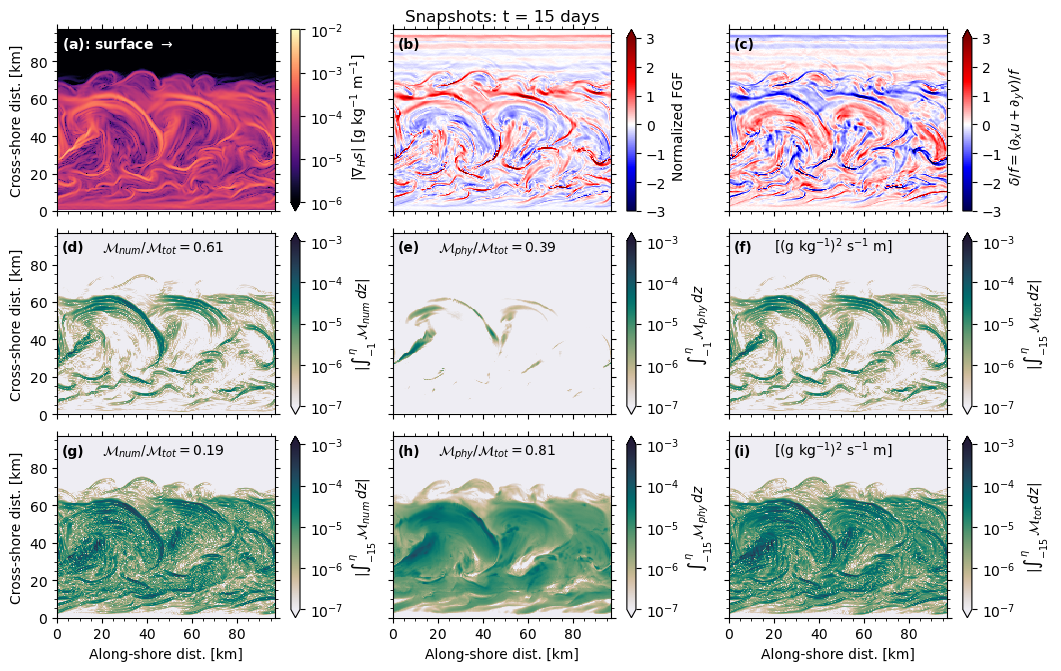

In [57]:
fig, ax = plt.subplots(3,3, figsize = ((7/2)*3,(8.66/4)*3.05), constrained_layout = True)

xrho = (ds.x_rho/1000)[1:].values
yrho = (ds.y_rho/1000)[1:].values

sfill3 = sgradmag[336-96,1:].where(sgradmag[336-96,1:]>1e-6)
sfill03 = sfill3.fillna(value=1e-6)

m0 = ax[0,0].pcolormesh(xrho, yrho, np.log10(sfill03), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
cbar = fig.colorbar(m0, ax = ax[0,0], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%d}$'))
cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

m1 = ax[0,1].pcolormesh(xrho, yrho, nDGQ2[336-96,-1,1:], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
cbar = fig.colorbar(m1, ax = ax[0,1], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'Normalized FGF')

m2 = ax[0,2].pcolormesh(xrho, yrho, delta[336-96,-1,1:], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
cbar = fig.colorbar(m2, ax = ax[0,2], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$\delta/f=(\partial_x u + \partial_y v)/f$')

m3 = ax[1,0].pcolormesh(xrho, yrho, np.log10(np.abs(mnum_z1[336-96,1:].values)), cmap = plt.get_cmap('cmo.rain'), vmin = -7, vmax = -3)
cbar = fig.colorbar(m3, ax = ax[1,0], label = r'$|\int_{-1}^\eta \, \mathcal{M}_{num} \, dz|$', extend = 'both', format=tick.FormatStrFormatter('$10^{%d}$'))

m4 = ax[1,1].pcolormesh(xrho, yrho, np.log10((mphy_z1[336-96,1:].values)), cmap = plt.get_cmap('cmo.rain'), vmin = -7, vmax = -3)
cbar = fig.colorbar(m4, ax = ax[1,1], label = r'$\int_{-1}^\eta \, \mathcal{M}_{phy} \, dz$', extend = 'both', format=tick.FormatStrFormatter('$10^{%d}$'))

m5 = ax[1,2].pcolormesh(xrho, yrho, np.log10(np.abs(mtot_z1[336-96,1:].values)), cmap = plt.get_cmap('cmo.rain'), vmin = -7, vmax = -3)
cbar = fig.colorbar(m5, ax = ax[1,2], label = r'$|\int_{-15}^\eta \, \mathcal{M}_{tot} \, dz|$', extend = 'both', format=tick.FormatStrFormatter('$10^{%d}$'))

m6 = ax[2,0].pcolormesh(xrho, yrho, np.log10((np.abs(mnum_z15[336-96,1:].values))), cmap = plt.get_cmap('cmo.rain'), vmin = -7, vmax = -3)
cbar = fig.colorbar(m6, ax = ax[2,0], label = r'$|\int_{-15}^\eta \, \mathcal{M}_{num} \, dz|$', extend = 'both', format=tick.FormatStrFormatter('$10^{%d}$'))

m7 = ax[2,1].pcolormesh(xrho, yrho, np.log10((mphy_z15[336-96,1:].values)), cmap = plt.get_cmap('cmo.rain'), vmin = -7, vmax = -3)
cbar = fig.colorbar(m6, ax = ax[2,1], label = r'$\int_{-15}^\eta \, \mathcal{M}_{phy} \, dz$', extend = 'both', format=tick.FormatStrFormatter('$10^{%d}$'))

m8 = ax[2,2].pcolormesh(xrho, yrho, np.log10(np.abs(mtot_z15[336-96,1:].values)), cmap = plt.get_cmap('cmo.rain'), vmin = -7, vmax = -3)
cbar = fig.colorbar(m6, ax = ax[2,2], label = r'$|\int_{-15}^\eta \, \mathcal{M}_{tot} \, dz|$', extend = 'both', format=tick.FormatStrFormatter('$10^{%d}$'))

for i in range(3):
    for j in range(3):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Cross-shore dist. [km]')
        ax[2,j].set_xlabel('Along-shore dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        ax[0,i].set_xticklabels([])
        ax[1,i].set_xticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)

ax[0,0].text(2,87, r'(a): surface $\rightarrow{}$', fontweight = 'semibold', color = 'white')
ax[0,1].text(2,87, '(b)', fontweight = 'semibold')
ax[0,2].text(2,87, '(c)', fontweight = 'semibold')
ax[1,0].text(2,87, '(d)', fontweight = 'semibold')
ax[1,0].text(20,87, '$\mathcal{M}_{num}/\mathcal{M}_{tot}= 0.61$')
ax[1,1].text(2,87, '(e)', fontweight = 'semibold')
ax[1,1].text(20,87, '$\mathcal{M}_{phy}/\mathcal{M}_{tot}= 0.39$')
ax[1,2].text(2,87, '(f)', fontweight = 'semibold')
ax[1,2].text(20,87, '[(g kg$^{-1}$)$^2$ s$^{-1}$ m]')
ax[2,0].text(2,87, '(g)', fontweight = 'semibold')
ax[2,0].text(20,87, '$\mathcal{M}_{num}/\mathcal{M}_{tot}= 0.19$')
ax[2,1].text(2,87, '(h)', fontweight = 'semibold')
ax[2,1].text(20,87, '$\mathcal{M}_{phy}/\mathcal{M}_{tot}= 0.81$')
ax[2,2].text(2,87, '(i)', fontweight = 'semibold')
ax[2,2].text(20,87, '[(g kg$^{-1}$)$^2$ s$^{-1}$ m]')
ax[0,1].set_title('Snapshots: t = 15 days')
plt.savefig('fig5_snapshots_day_15.jpg', dpi = 400, bbox_inches='tight')

## Some interesting trends emerge. 
We can see that the nFGF is negatively correlated with the divergence, which is consistent with Barkan et al. (2019) JPO. Make a scatter plot to investigate further

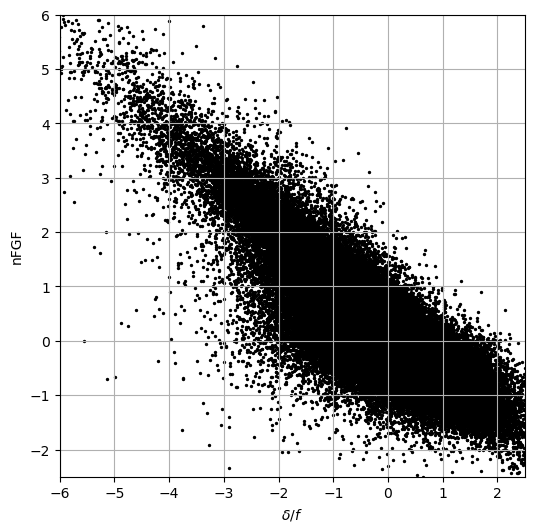

In [65]:
fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(delta[200:247,-1,1:], nDGQ2[200:247,-1,1:], c = 'k', s = 2)
plt.ylabel('nFGF')
plt.xlabel('$\delta/f$')
plt.ylim(-2.5,6)
plt.xlim(-6,2.5)
plt.grid()
plt.savefig('delta_nfgf.jpg', dpi = 400, bbox_inches='tight')